<a href="https://colab.research.google.com/github/Orth33/walmart-sales-prediction/blob/main/Walmart_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup and Data Loading**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'walmart-sales-forecast' dataset.
Path to dataset files: /kaggle/input/walmart-sales-forecast


In [ ]:
# 1. Load the datasets
# We assume the files are in the root content folder of Colab
train_df = pd.read_csv("/kaggle/input/walmart-sales-forecast/train.csv")
features_df = pd.read_csv("/kaggle/input/walmart-sales-forecast/features.csv")
stores_df = pd.read_csv("/kaggle/input/walmart-sales-forecast/stores.csv")

In [ ]:
# 2. Quick Inspection
print("--- Train Data ---")
display(train_df.head(3))

print("\n--- Features Data ---")
display(features_df.head(3))

print("\n--- Stores Data ---")
display(stores_df.head(3))

--- Train Data ---


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False



--- Features Data ---


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False



--- Stores Data ---


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


In [ ]:
# 3. Check data types and dataset size
print("\n--- Data Info ---")
print(train_df.info())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None


# **Merging and Cleaning**

In [ ]:
# 1. Merge Stores data into Train data
# We match them based on the 'Store' column
df = train_df.merge(stores_df, on='Store', how='left')

# 2. Merge Features data into the result
# We match on 'Store', 'Date', and 'IsHoliday' to ensure everything aligns perfectly
df = df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

# 3. Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# 4. Handle Missing Values
# In this dataset, NaN in MarkDown columns means "No Markdown". We replace NaN with 0.
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# 5. Final check
print("--- Final Dataset Shape ---")
print(df.shape)
print("\n--- Data Types ---")
print(df.dtypes)
print("\n--- Missing Values Check ---")
print(df.isna().sum())

display(df.head())

--- Final Dataset Shape ---
(421570, 16)

--- Data Types ---
Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
dtype: object

--- Missing Values Check ---
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


# **Feature Engineering**

In [ ]:
# 1. Basic Time Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int) # ISO week number
df['Day'] = df['Date'].dt.day

# 2. Lag Features (Sales from previous weeks)
# We sort by date first to ensure the shift is chronological
df = df.sort_values(by=['Store', 'Dept', 'Date'])

# Create a 1-week and 2-week lag
df['Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df['Lag_2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)

# 3. Rolling Mean (Bonus Task)
# Average sales of the last 4 weeks (1 month rolling)
df['Rolling_Mean_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4).mean()
)

# 4. Handle NaNs created by lagging
# The first few rows of each Store/Dept will have NaNs because there is no "previous" week
df = df.fillna(0)

# 5. One-Hot Encoding for 'Type'
# Convert categorical 'Type' (A, B, C) into numerical columns
df = pd.get_dummies(df, columns=['Type'], prefix='Type')

print("New features created!")
print(f"Total columns now: {len(df.columns)}")
display(df[['Date', 'Store', 'Dept', 'Weekly_Sales', 'Lag_1', 'Rolling_Mean_4']].head(10))

New features created!
Total columns now: 25


,Date,Store,Dept,Weekly_Sales,Lag_1,Rolling_Mean_4
0,2010-02-05,1,1,24924.50,0.00,0.0000
1,2010-02-12,1,1,46039.49,24924.50,0.0000
2,2010-02-19,1,1,41595.55,46039.49,0.0000
3,2010-02-26,1,1,19403.54,41595.55,32990.7700
4,2010-03-05,1,1,21827.90,19403.54,32216.6200
5,2010-03-12,1,1,21043.39,21827.90,25967.5950
6,2010-03-19,1,1,22136.64,21043.39,21102.8675
7,2010-03-26,1,1,26229.21,22136.64,22809.2850
8,2010-04-02,1,1,57258.43,26229.21,31666.9175
9,2010-04-09,1,1,42960.91,57258.43,37146.2975


# **Training and Evaluation**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Define Features and Target
# We drop 'Date' (it's not a number) and 'Weekly_Sales' (that's what we want to predict)
X = df.drop(['Weekly_Sales', 'Date'], axis=1)
y = df['Weekly_Sales']

# 2. Time-Based Split
# Let's take the last 20% of the data chronologically for testing
split_point = int(len(df) * 0.8)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"Training rows: {len(X_train)}")
print(f"Testing rows: {len(X_test)}")

# 3. Model Initialization & Training
# n_estimators=20 for speed in Colab; increase to 100 later for better accuracy
model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 4. Predictions
predictions = model.predict(X_test)

# 5. Metrics
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"\nMean Absolute Error (MAE): ${mae:.2f}")
print(f"R-squared Score: {r2:.4f}")

Training rows: 337256
Testing rows: 84314

Mean Absolute Error (MAE): $853.90
R-squared Score: 0.9798


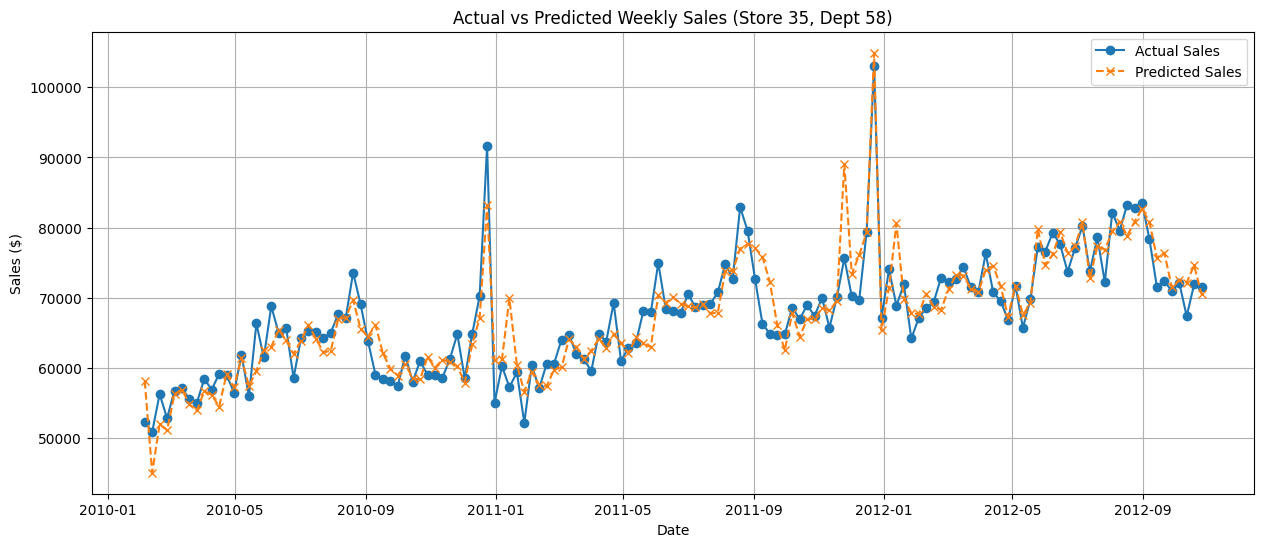

In [ ]:
# Create a comparison dataframe
test_results = df.iloc[split_point:].copy()
test_results['Predictions'] = predictions

# Let's plot Store 35, Dept 58 to see how we did
sample_store = test_results[(test_results['Store'] == 39) & (test_results['Dept'] == 2)]

plt.figure(figsize=(15, 6))
plt.plot(sample_store['Date'], sample_store['Weekly_Sales'], label='Actual Sales', marker='o')
plt.plot(sample_store['Date'], sample_store['Predictions'], label='Predicted Sales', linestyle='--', marker='x')
plt.title('Actual vs Predicted Weekly Sales (Store 35, Dept 58)')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Check which stores are available in your test set
print("Stores available in the test set:", test_results['Store'].unique())

Stores available in the test set: [35 36 37 38 39 40 41 42 43 44 45]


In [ ]:
print("Departments available for Store 39 in the test set:", test_results[test_results['Store'] == 39 ]['Dept'].unique())

Departments available for Store 39 in the test set: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 38 40 41 42 44 45 46 47 49 51 52 54 55
 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94 95 96
 97 98 99]


/tmp/ipython-input-2583553384.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sample_series = sample_series.resample('W').mean().fillna(method='ffill')


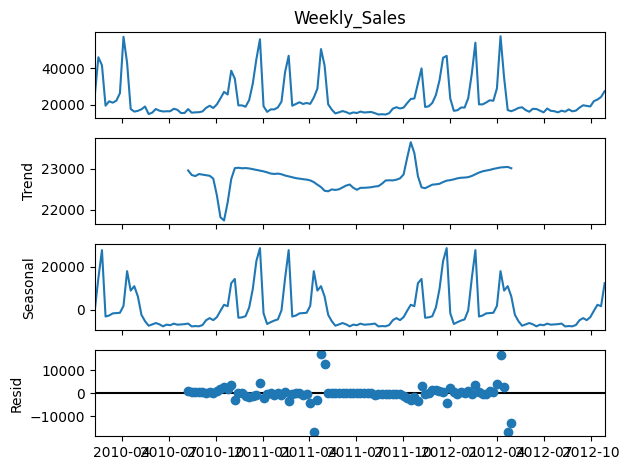

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We need a continuous time series for one specific store/dept
sample_series = df[(df['Store'] == 1) & (df['Dept'] == 1)].set_index('Date')['Weekly_Sales']
sample_series = sample_series.resample('W').mean().fillna(method='ffill')

decomposition = seasonal_decompose(sample_series, model='additive', period=52) # 52 weeks in a year
decomposition.plot()
plt.show()

# **Training with XGBoost**

In [ ]:
import xgboost as xgb

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train)

XGBoost MAE: $984.81


In [ ]:
# Predict and Evaluate
xgb_preds = xgb_model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"XGBoost MAE: ${mean_absolute_error(y_test, xgb_preds):.2f}")
print(f"XGBoost R2: {r2:.4f}")

XGBoost MAE: $984.81
XGBoost R2: 0.9798


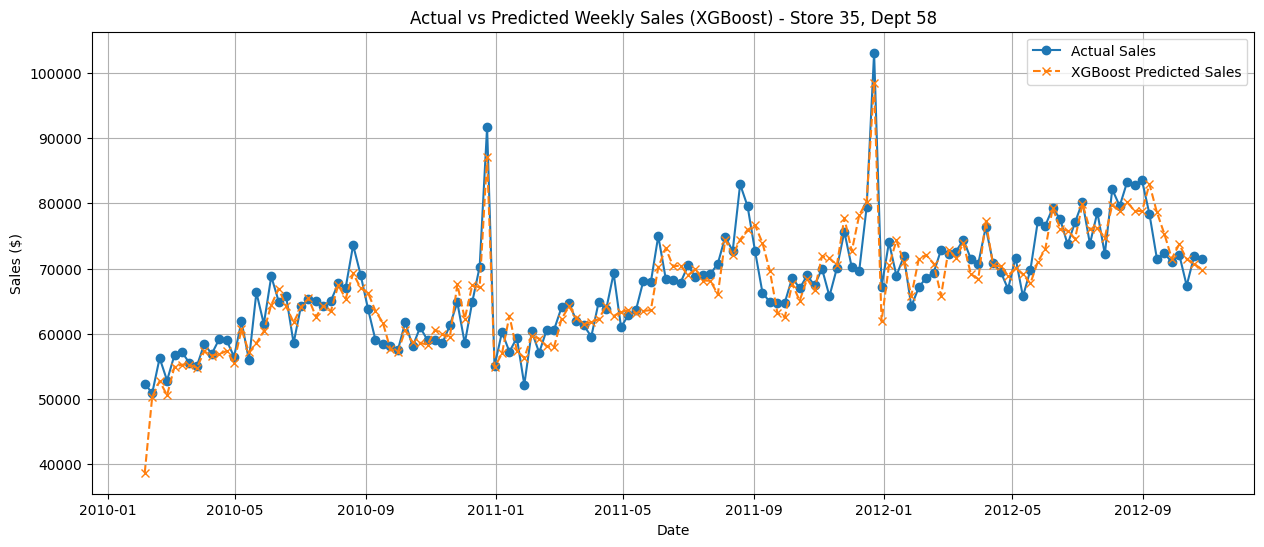

In [ ]:
# Create a comparison dataframe for XGBoost results
test_results_xgb = df.iloc[split_point:].copy()
test_results_xgb['XGB_Predictions'] = xgb_preds

# Let's plot Store 35, Dept 58 to see how XGBoost did
sample_store_xgb = test_results_xgb[(test_results_xgb['Store'] == 39) & (test_results_xgb['Dept'] == 2)]

plt.figure(figsize=(15, 6))
plt.plot(sample_store_xgb['Date'], sample_store_xgb['Weekly_Sales'], label='Actual Sales', marker='o')
plt.plot(sample_store_xgb['Date'], sample_store_xgb['XGB_Predictions'], label='XGBoost Predicted Sales', linestyle='--', marker='x')
plt.title('Actual vs Predicted Weekly Sales (XGBoost) - Store 35, Dept 58')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True)
plt.show()

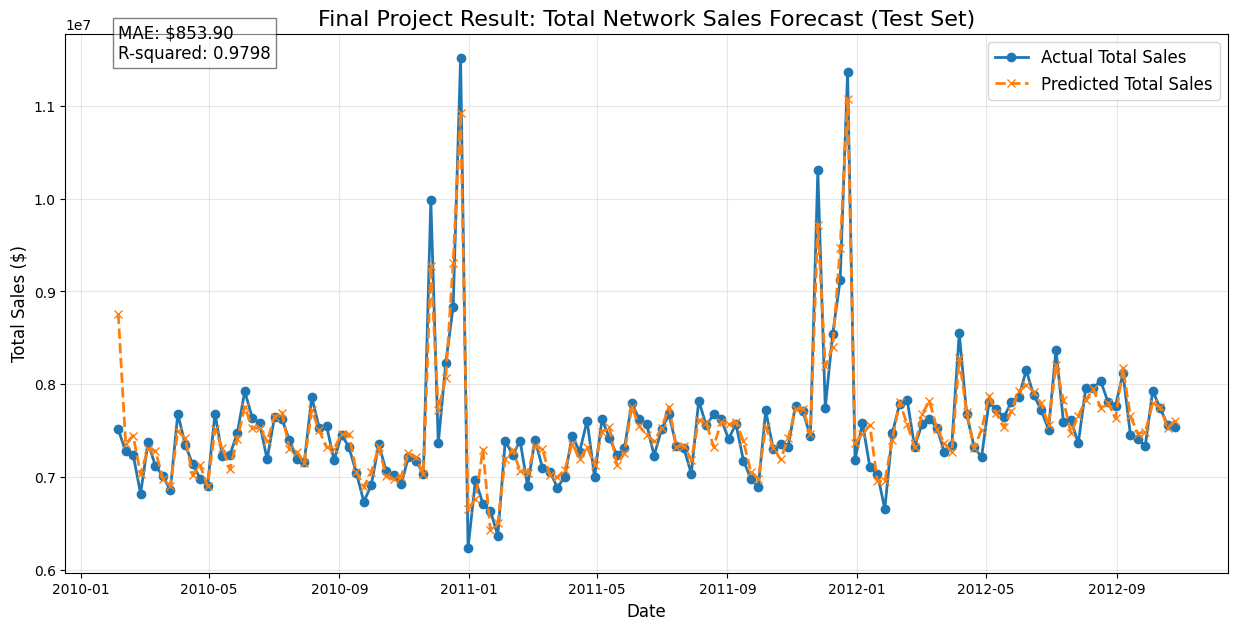

In [ ]:
# 1. Group the test results by Date to see the total trend
total_forecast = test_results.groupby('Date')[['Weekly_Sales', 'Predictions']].sum().reset_index()

# 2. Plotting
plt.figure(figsize=(15, 7))
plt.plot(total_forecast['Date'], total_forecast['Weekly_Sales'],
         label='Actual Total Sales', color='#1f77b4', linewidth=2, marker='o')
plt.plot(total_forecast['Date'], total_forecast['Predictions'],
         label='Predicted Total Sales', color='#ff7f0e', linewidth=2, linestyle='--', marker='x')

plt.title('Final Project Result: Total Network Sales Forecast (Test Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add a text box with your metrics for the presentation
stats_text = f'MAE: ${mae:.2f}\nR-squared: {r2:.4f}'
plt.text(total_forecast['Date'].iloc[0], total_forecast['Weekly_Sales'].max(),
         stats_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()